In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mathkit.matrix_la.sys_mtx_assembly import SysMtxAssembly
import numpy as np
import sympy as sp
sp.init_printing()

Given are the external stress resultants 
\begin{align}
M, Q, N
\end{align}

In [2]:
H, L, B = sp.symbols('H, L, B', real=True)

End displacement of the zone 

In [3]:
U, W, Phi = sp.symbols('U, W, Phi', real=True)

# Uncracked zone
To start with the derivation let us first consider a zone without crack which is clamped at the right hand side. The stress resultants corresponding to the unit displacements $U$, $W$, $\Phi$ are the stiffness terms from a beam theory. As a warm up for this notebook, let us re-invent them using the `sympy` symbolic derivation. 

The stress state within a ligament of a cross section as a function of $z$ is expressed by the normal stress $\sigma$ and shear stress $\tau$. Within a segment of a length $L$ they are both assumed to be constant. Further, assuming elastic behavior, we can write   

Considering a shear profile 

Global equilibrium delivers the conditions
\begin{align}
 M_0 + M_L + Q L &= 0 \\
 Q_0 - Q_L &= 0 \\
 N_0 - N_L &= 0 
\end{align}

On the other hand, assuming 

Localization length is used to transform the crack opening at the crack tip
to the tensile strain within that zone.

In [4]:
L_, H_, B_ =  100, 60, 20
x_aC = np.array([[0, L_, L_, 0], 
                 [0, 0, H_, H_]], dtype=np.float_)

In [5]:
x_Ca = x_aC.T
C_Li = np.array([[0,1],[1,2],[2,3],[3,0]], dtype=np.int_).T
C_Li

array([[0, 1, 2, 3],
       [1, 2, 3, 0]])

In [6]:
x_aI = np.array([
    [80., 79., 77., 76., 73., 60., 55., 49., 40., 35],
    [ 0.,  6., 12., 16., 22., 40., 44., 46., 48., 49]
], dtype=np.float_)

In [7]:
x_iMa = x_aC.T[C_Li]
np.einsum('iMa->aiM', x_iMa)
x_aiM = np.einsum('Mia->aiM', x_aC.T[C_Li])
x_aiM

array([[[  0., 100.],
        [100., 100.],
        [100.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,  60.],
        [ 60.,  60.],
        [ 60.,   0.]]])

In [8]:
def plot_sz_geo(ax, x_aI=x_aI, x_aC=x_aC):
    x_aiM = np.einsum('Mia->aiM', x_aC.T[C_Li])
    ax.plot(*x_aiM, color='black');
    ax.plot(*x_aI, lw=2, color='blue');
print(*x_aiM)

[[  0. 100.]
 [100. 100.]
 [100.   0.]
 [  0.   0.]] [[ 0.  0.]
 [ 0. 60.]
 [60. 60.]
 [60.  0.]]


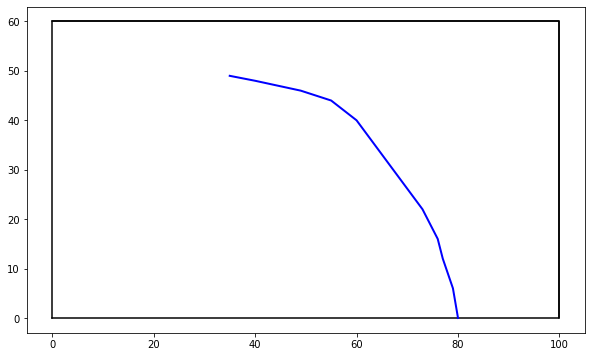

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_sz_geo(ax)

In [10]:
N_I = np.arange(len(x_Ia))
I_Li = np.array([N_I[:-1], N_I[1:]], dtype=np.int_).T
N_I

NameError: name 'x_Ia' is not defined

In [ ]:
x_Lia = x_Ia[I_Li] 

In [ ]:
n_vec_La = x_Lia[:,1,:] - x_Lia[:,0,:]
n_vec_La

In [ ]:
normed_n_vec_La = np.einsum('...a,...->...a',
    n_vec_La, 1. / np.linalg.norm(n_vec_La,axis=-1)
)

In [ ]:
EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1
Z = np.array([0,0,1], dtype=np.float_)

In [ ]:
t_vec_La = np.einsum('ijk,...j,k->...i', 
                      EPS[:-1,:-1,:], normed_n_vec_La, Z);
o_base_bLa = np.array([normed_n_vec_La, t_vec_La])
o_base_Lab = np.einsum('bLa->Lab', o_base_bLa)

In [ ]:
plot_scale = 3.0
x_n0_Mca = np.einsum(
    'c,Ma->Mca',np.ones((2,)), (np.sum(x_Lia[:,:,:], axis=1)/2))
x_n0_Mca + plot_scale*o_base_Lab
x_n_iMca = np.array(
    [x_n0_Mca, x_n0_Mca + plot_scale*o_base_Lab[:,:,:]]
)
x_n_caiM = np.einsum('iMca->caiM', x_n_iMca)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_sz_geo(ax)
ax.plot(*x_n_caiM.reshape(-1,2,len(I_Li)), color='orange',lw=3);

In [ ]:
U, W, Phi

In [ ]:
U_vct = np.array([1, 5], dtype=np.float_)

In [ ]:
def move(x_Ia):
    return x_Ia[:,:] + U_vct[np.newaxis,:] 

In [ ]:
xu_Ia = move(x_Ia)
xu_Ca = move(x_Ca)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_sz_geo(ax)
plot_sz_geo(ax,x_aI=xu_Ia.T, x_aC=xu_Ca.T)

In [ ]:
CR = (x_Ca[1] + x_Ca[2])/2
Phi = 0.01

In [ ]:
rot_mtx = np.array(
    [[np.cos(Phi), -np.sin(Phi)],
     [np.sin(Phi), np.cos(Phi)]], dtype=np.float_)

In [ ]:
def rotate(x_Ia):
    u_Ib = np.einsum(
        'ab,...b->...a',
        rot_mtx, x_Ia - CR
    )
    return u_Ib + CR 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_sz_geo(ax)
plot_sz_geo(ax,x_aI=rotate(move(x_Ia)).T, x_aC=rotate(move(x_Ca)).T)

In [ ]:
u_Ia = rotate(move(x_Ia)) - x_Ia

In [ ]:
u_Lia = u_Ia[I_Li]

In [ ]:
u_Lib = np.einsum(
    'Lia,Lab->Lib',u_Lia, o_base_Lab
)
u_Lb = np.sum(u_Lib,axis=1)
u_Lb[:,0]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_sz_geo(ax)
plot_sz_geo(ax,x_aI=rotate(move(x_Ia)).T, x_aC=rotate(move(x_Ca)).T)
xxx, yyy =x_n_caiM[1,:,:]
ax.plot(xxx, yyy, color='orange',lw=3);